In [1]:
### Import libraries

import igraph as ig
import numpy as np
import os
from collections import Counter, OrderedDict
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from auxiliar_bb import apply_backboning
from auxiliar_projections_large import apply_projection
from auxiliar_optimization import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

In [2]:
### Select dataset
DATASET = "um" # ["amz", "um", "am"]
PROJ_NAMES = ["simple", "vector", "jaccard", "neighs", "hyper", "resall"]

nombre_proyecciones = {
    "simple": "Weighted", "jaccard": "Jaccard", "hyper": "Hyperbolic",
    "vector": "Vectorized", "resall": "Resource\nAllocation", "neighs": "Neighborhood"
}
nombre_backbonings = { "NC": "Noise Corrected", "DF": "Disparity Filter"}
COLORS_PR = ["#ef476fff", "#f78c6bff", "#ffd166ff", "#06d6a0ff", "#118ab2ff", "#718355"]
COLORS_BB = [ "#8ab17d", "#e9c46a"]
COLORS_SV = ["#718355", "#87986a", "#97a97c", "#b5c99a"]

if DATASET == "um":
    FILENAME = "../12-third_year/00-Data/08-imdb/user-movie.graphml"
elif DATASET == "am":
    FILENAME = "/home/daniel/Documents/phd/phd-thesis-lab/12-third_year/00-Data/05-actor-movie/actor-movie.graphml"
elif DATASET == "amz":
    FILENAME = "binet-AMZ-Rw.graphml"


### Load Dataset

In [3]:
g = ig.read(FILENAME)
print(g.summary())
print()

top_nodes = g.vs.select(type=0)
bot_nodes = g.vs.select(type=1)

print("|U|=",len(top_nodes), " \t|R|=",len(bot_nodes), " \t|U|+|R|=",
      len(top_nodes)+len(bot_nodes), "=", g.vcount())
print()

if(g.is_bipartite()): # Check if the the graph is bipartite
    print("The graph IS bipartite")
else:
    print("The graph IS NOT bipartite")
    exit()


IGRAPH UN-T 1199919 3782463 -- 
+ attr: id (v), name (v), type (v)

|U|= 896302  	|R|= 303617  	|U|+|R|= 1199919 = 1199919

The graph IS bipartite


In [4]:
NODETYPE = 0    # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 896302,
 'x2': 303617,
 'x3': 3782463,
 'x8': 0.312,
 'x9': 6.75606,
 'x11': 4.4055208,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 896302,
 'x2': 303617,
 'x3': 3782463,
 'x8': 0.312,
 'x9': 6.75606,
 'x11': 4.4055208,
 'x15': 5.254134495700971e-06,
 'x16': 4.220076492075216}

In [5]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
#a = pd.DataFrame(to_df, columns=['f1', 'f2'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 20


In [6]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)

#analizar_frente(counter_sols, DATASET.upper()+" Top")


Frente 1 (13 soluciones):
esall_NC_a2
yper_NC_a2
imple_NC_a15
eighs_NC_a15
yper_NC_a05
eighs_NC_a05
esall_NC_a05
accard_NC_a2
imple_NC_a2
esall_NC_a1
esall_NC_a15
imple_NC_a05
eighs_NC_a2

Frente 2 (5 soluciones):
accard_NC_a05
accard_NC_a15
yper_NC_a15
imple_NC_a1
eighs_NC_a1

Frente 3 (2 soluciones):
accard_NC_a1
yper_NC_a1


Matriz de correlación:
          f1        f2        f3        f4        f5        f6
f1  1.000000  0.894630  0.873330 -0.952836  0.561007  0.610100
f2  0.894630  1.000000  0.963045 -0.923299  0.802276  0.669423
f3  0.873330  0.963045  1.000000 -0.951040  0.871204  0.709264
f4 -0.952836 -0.923299 -0.951040  1.000000 -0.756663 -0.691674
f5  0.561007  0.802276  0.871204 -0.756663  1.000000  0.657060
f6  0.610100  0.669423  0.709264 -0.691674  0.657060  1.000000


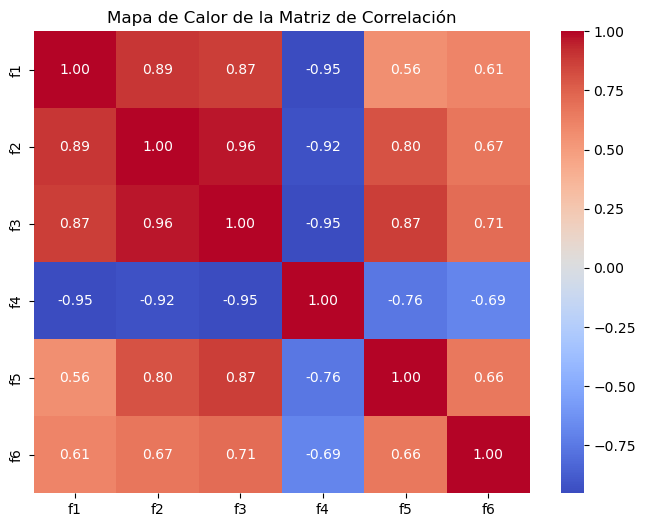

In [7]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-1]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()

In [8]:
NODETYPE = 1   # 0=Top     1=Bot

# 1) Reading the bipartite networks
gb = ig.Graph.Read_GraphML(FILENAME)
bip_metrics = {'x1': 896302,
 'x2': 303617,
 'x3': 3782463,
 'x8': 0.312,
 'x9': 6.75606,
 'x11': 4.4055208,
 'x15':gb.density(),
 'x16': statistics.mean(gb.degree(gb.vs.select(type=NODETYPE)))}
bip_metrics

{'x1': 896302,
 'x2': 303617,
 'x3': 3782463,
 'x8': 0.312,
 'x9': 6.75606,
 'x11': 4.4055208,
 'x15': 5.254134495700971e-06,
 'x16': 12.458007950806444}

In [9]:
# Directorio de proyecciones
proj_dir = DATASET + ("/top" if NODETYPE == 0 else "/bot")

# Directorio para guardar métricas cacheadas
metrics_cache_dir = os.path.join(proj_dir, "cached_metrics")
os.makedirs(metrics_cache_dir, exist_ok=True)

# Lista de archivos de métricas
metrics_files = [f for f in os.listdir(metrics_cache_dir) if f.endswith("_metrics.pkl")]

solutions = []
to_df = []
names_df = []

for fname in metrics_files:
    cache_path = os.path.join(metrics_cache_dir, fname)

    # Cargar las métricas ya calculadas
    with open(cache_path, 'rb') as f:
        proj_metrics = pickle.load(f)

    # Nombre base del archivo (quita el sufijo "_metrics.pkl")
    base_name = fname.replace("_metrics.pkl", "")

    sol = evaluate_solution(bip_metrics, proj_metrics, NODETYPE)
    to_df.append(sol["f"])
    names_df.append(base_name)
    sol["filename"] = base_name

    if is_feasible(sol):
        solutions.append(sol)

# Crear dataset final
a = pd.DataFrame(to_df, columns=['f1', 'f2', 'f3', 'f4', 'f5', 'f6'])
b = pd.DataFrame(names_df, columns=["name"])
final_DF = pd.concat([a, b], axis=1)

print("All solutions:", len(metrics_files))
print("Feasible solutions:", len(solutions))


All solutions: 40
Feasible solutions: 26


In [10]:
### Compute the pareto fronts

all_fronts = pareto_rank_all(solutions)
counter_sols = []

for rank, front in enumerate(all_fronts, 1):
    print(f"\nFrente {rank} ({len(front)} soluciones):")
    for sol_i in front:
        clean_name = sol_i["filename"][8:]
        print(clean_name)
        counter_sols.append(clean_name)



Frente 1 (24 soluciones):
accard_NC_a1
esall_DF_a05
imple_DF_a2
accard_NC_a15
esall_DF_a1
imple_NC_a05
eighs_NC_a15
imple_DF_a15
esall_NC_a1
eighs_NC_a1
yper_NC_a2
esall_DF_a2
eighs_NC_a05
yper_NC_a05
esall_DF_a15
imple_NC_a1
eighs_NC_a2
yper_NC_a15
imple_NC_a2
imple_NC_a15
esall_NC_a2
esall_NC_a05
esall_NC_a15
accard_NC_a2

Frente 2 (2 soluciones):
accard_NC_a05
yper_NC_a1


Matriz de correlación:
          f1        f2        f3        f4        f5        f6
f1  1.000000 -0.732602  0.839041 -0.626850 -0.428796  0.456731
f2 -0.732602  1.000000 -0.877046  0.954354  0.761053 -0.347272
f3  0.839041 -0.877046  1.000000 -0.768242 -0.397280  0.457499
f4 -0.626850  0.954354 -0.768242  1.000000  0.749602 -0.276783
f5 -0.428796  0.761053 -0.397280  0.749602  1.000000 -0.148742
f6  0.456731 -0.347272  0.457499 -0.276783 -0.148742  1.000000


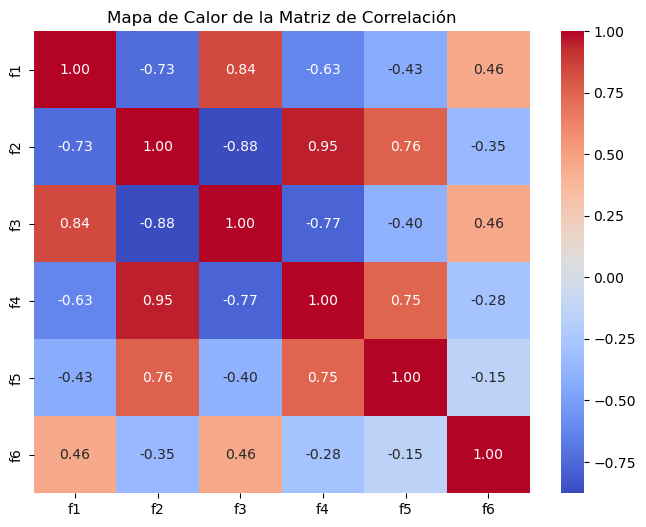

In [11]:
# Calculamos la matriz de correlación
correlation_matrix = final_DF[final_DF.columns[:-1]].corr()

print("Matriz de correlación:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Usamos la matriz de correlación que calculamos antes
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Calor de la Matriz de Correlación')
plt.show()